In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [4]:
β1 = 0.015
β2 = 0.0077 # (0.8/30/sqrt(12))
β3 = 0.0058 # (0.8/40/sqrt(12))

# flat prior for the pixel size
prior =  NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.065, 0.25), truncated(Normal(0.2, 0.04), 0.065, 0.25)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.065, 0.25), truncated(Normal(0.2, 0.04), 0.065, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
        mixt_pow =  0.52 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
        cam4_psy = truncated(Normal(120.0, 120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );  

labels = [L"\sigma_x", L"\sigma_y", L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", L"s",
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [5]:
FPATH = "../../data/sampling_results/Benchmark-4/"

"../../data/sampling_results/Benchmark-4/"

In [6]:
readdir(FPATH)

8-element Array{String,1}:
 "hc-1.hdf5"
 "hc-113.hdf5"
 "hc-188.hdf5"
 "hc-2.hdf5"
 "lc-1.hdf5"
 "lc-137.hdf5"
 "lc-151.hdf5"
 "lc-169.hdf5"

In [7]:
filename = readdir(FPATH)[2]
smpl_tmp = bat_read(FPATH*filename)
samples = varshape(prior).(smpl_tmp);

# lc-225.hdf5" is possybly wrong 

In [8]:
filename

"hc-113.hdf5"

In [9]:
smpl_vect = mode(samples)

ShapedAsNT((tr_size = [0.07311391386946396, 0.07180286259048073], tr_size_2 = [0.10075368027746544, 0.1088560446152663], ang_spr = [5.4659905299222205, 6.318269668656793], ang_spr_2 = [2.021027775976964, 2.860678347708307], mixt_pow = 0.6547754150232509, waist = [3.118113660203227], waist_2 = [2.824165902535189], algmx = [37.039606620174894, 37.6159570385378, 20.873881390416344, 34.235384714353884], algmy = [34.04279484955378, 35.40023554235552, 21.848232688262744, 34.93164323003137], cam4_ped = 26.577369042436537, cam4_light_fluct = 1.6141146710211698, cam4_light_amp = 8.045183910483594, resx = [0.6258625231152675, 4.103002239951209, 1.1598086724056396], resy = [0.8765662785131719, 2.9552452259642283, 1.079809840635268], cam4_resx = 4.34791451852207, cam4_resy = 3.1462434833612263, psx = [26.27065003745883, 21.656505893872993, 124.41190743139572], psy = [27.922179978914826, 23.336711893710344, 129.65875319724816], cam4_psx = 114.51178787903588, cam4_psy = 117.95666351463217, light_amp

In [10]:
# hist_tmp = hist_2d(samples, 1,2, nbins=40,)

# valss = sort([hist_tmp.weights...])
# valss_rc = valss ./ sum(valss)
# intt = [0.0001, 0.001, 0.006, 0.9999, 1]
# cvals = unique([valss[argmin(abs.(valss_rc .- i))] for i in intt])

# fig, ax= plt.subplots(1,1, figsize=(6,6))

# ax.contourf(
#     midpoints(hist_tmp.edges[1]), 
#     midpoints(hist_tmp.edges[2]), 
#     hist_tmp.weights', 
#     levels= 4, #cvals, 
#     cmap="Blues", alpha=0.6, antialiased=true) 

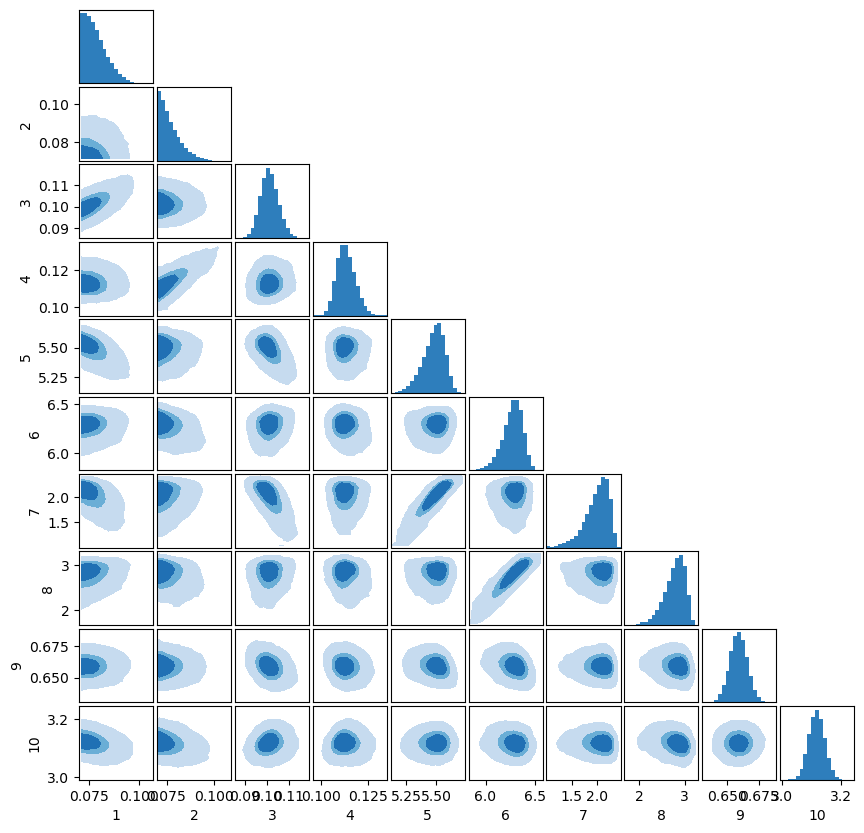

In [11]:
dims = [1,2,3,4,5,6,7,8,9,10]
names = [1,2,3,4,5,6,7,8,9,10]
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

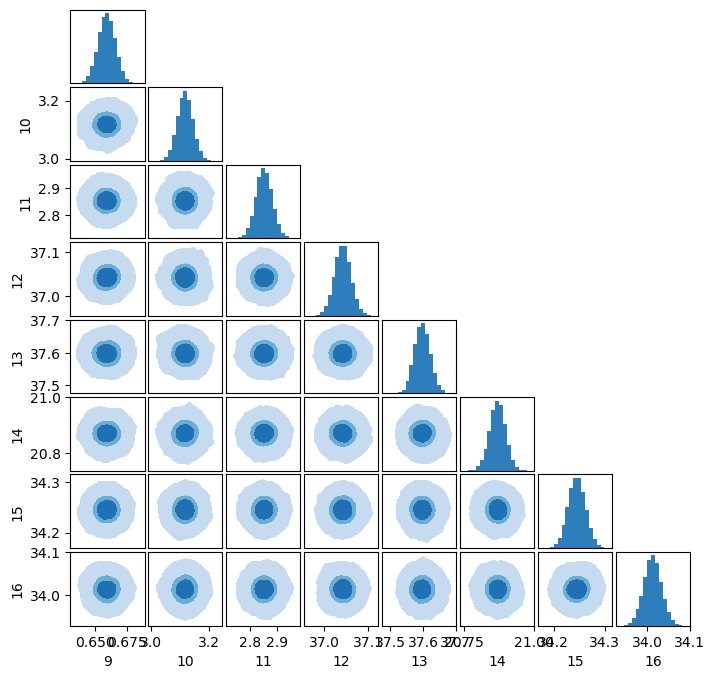

In [12]:
dims = [9,10,11,12,13,14, 15, 16]
names = [9,10,11,12,13,14, 15, 16]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

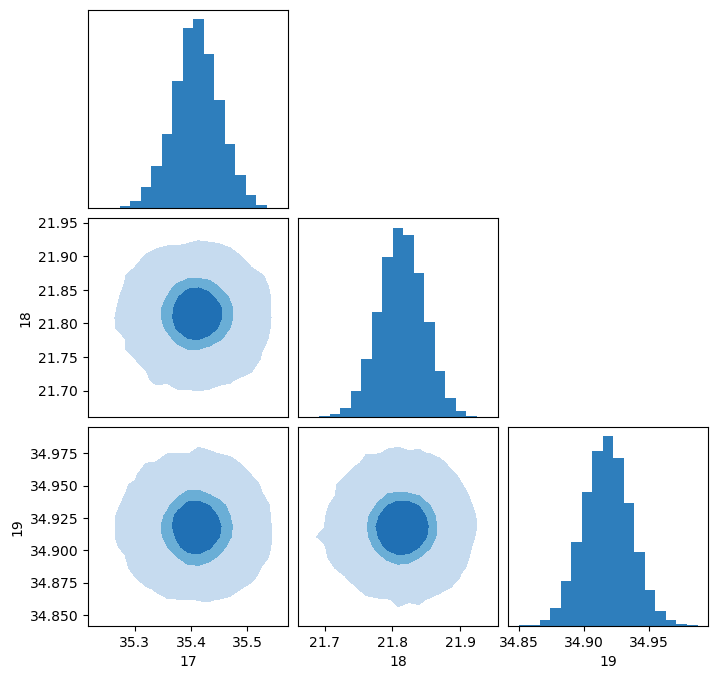

In [13]:
dims = [17,18,19]
names = [17,18,19]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

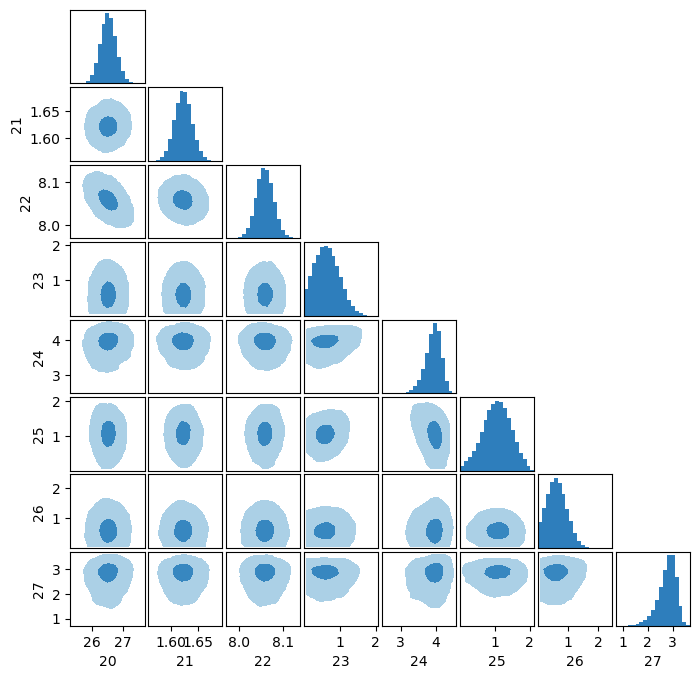

In [14]:
dims = [20,21,22,23,24,25,26,27]
names = [20,21,22,23,24,25,26,27]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [15]:
dims = [28,29,30,31,32,33,34,35]
names = [28,29,30,31,32,33,34,35]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /user/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1565, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6345, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 822, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1419, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1490, in _contour_args
    self._contour_level_args(z, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1174, in _contour_level_args
    raise ValueError("Contour levels must be increasing")


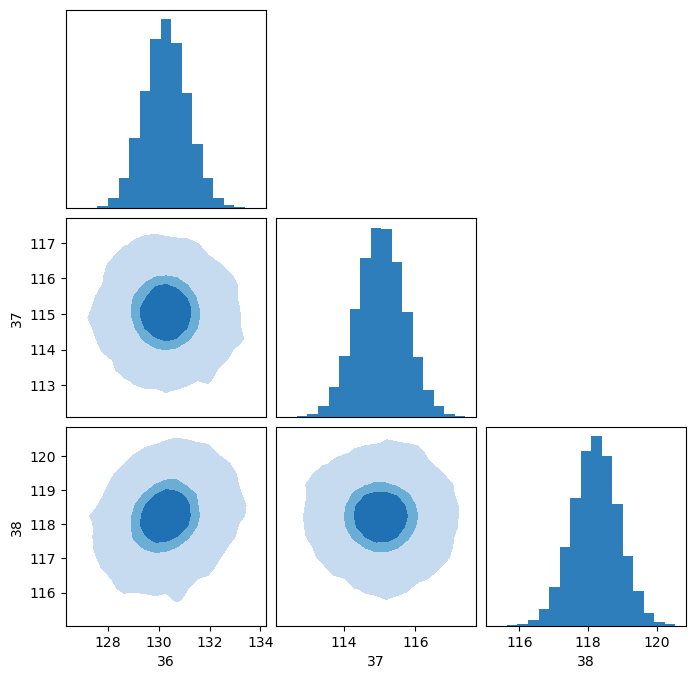

In [16]:
dims = [36,37,38]
names = [36,37,38]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

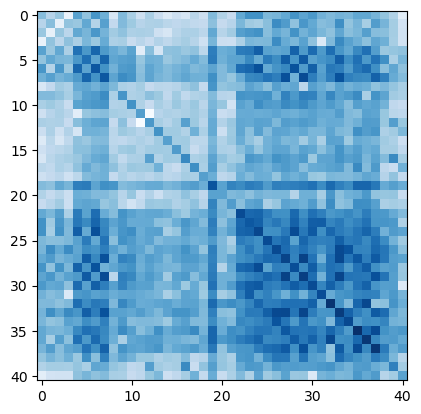

PyObject <matplotlib.image.AxesImage object at 0x7fae97d45b80>

In [17]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

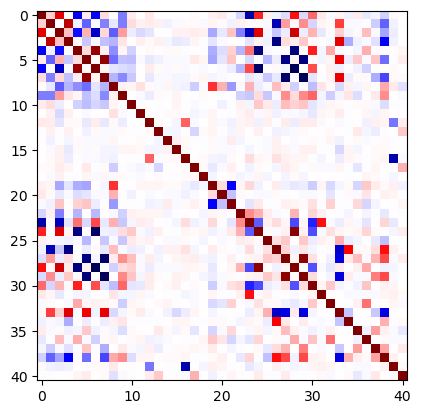

PyObject <matplotlib.image.AxesImage object at 0x7fae97cc57f0>

In [18]:
dt_reg = flatview(unshaped.(samples.v)) ./ std(flatview(unshaped.(samples.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [19]:
if filename[1:2] == "hc"
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

(cam_1 = [0.0 251.0 … 0.0 3.0; 0.0 0.0 … 0.0 0.0; … ; 2.0 0.0 … 134.0 0.0; 248.0 0.0 … 0.0 0.0], cam_2 = [0.0 0.0 … 7.0 7.0; 0.0 0.0 … 3.0 4.0; … ; 0.0 53.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], cam_3 = [124.0 28.0 … 0.0 5.0; 36.0 53.0 … 34.0 41.0; … ; 8.0 1.0 … 4.0 503.0; 0.0 44.0 … 314.0 7.0], cam_4 = [21.0 18.0 … 26.0 19.0; 24.0 18.0 … 23.0 18.0; … ; 18.0 16.0 … 19.0 18.0; 19.0 17.0 … 26.0 14.0], population = 23.962299346923828)

In [20]:
if filename[1:2] == "lc"
    @show "true"
    conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

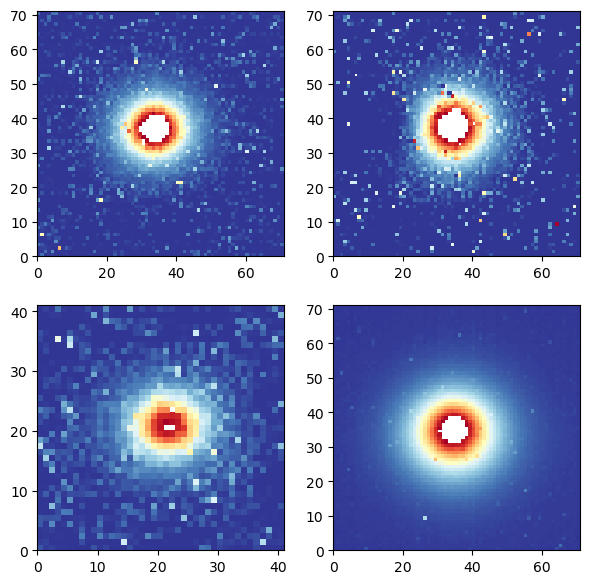

PyObject <matplotlib.collections.QuadMesh object at 0x7fae97cc5a30>

In [21]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

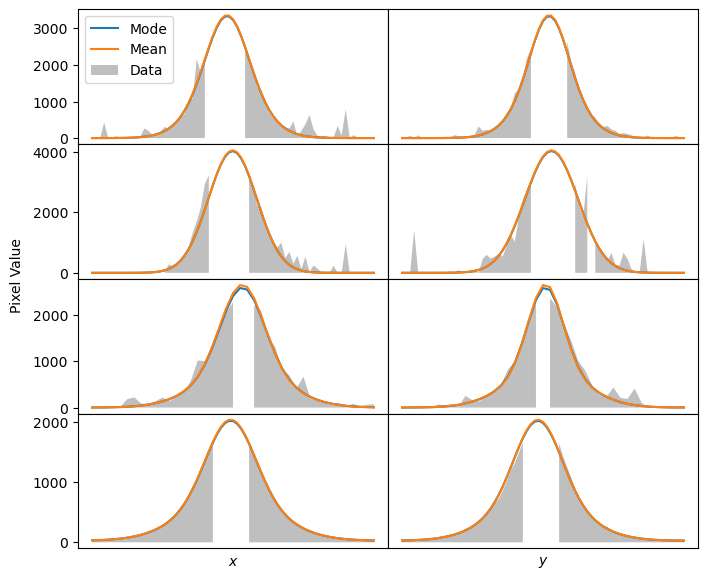

PyObject Text(0.04, 0.5, 'Pixel Value')

In [22]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

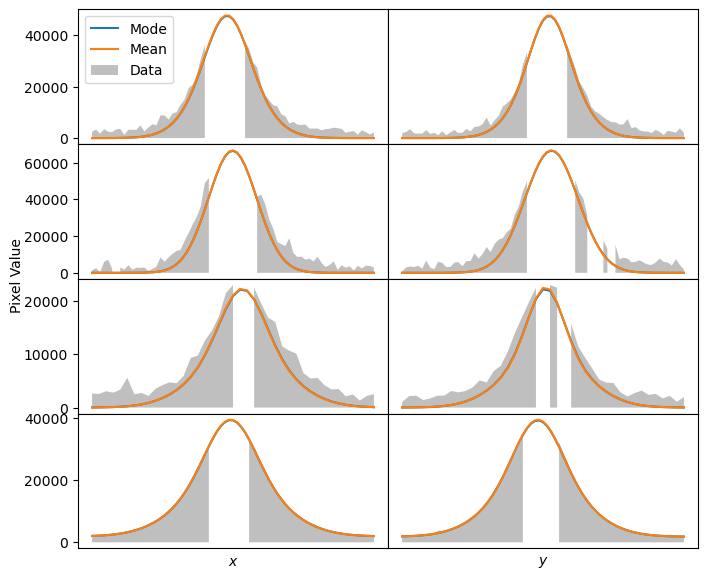

PyObject Text(0.04, 0.5, 'Pixel Value')

In [23]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

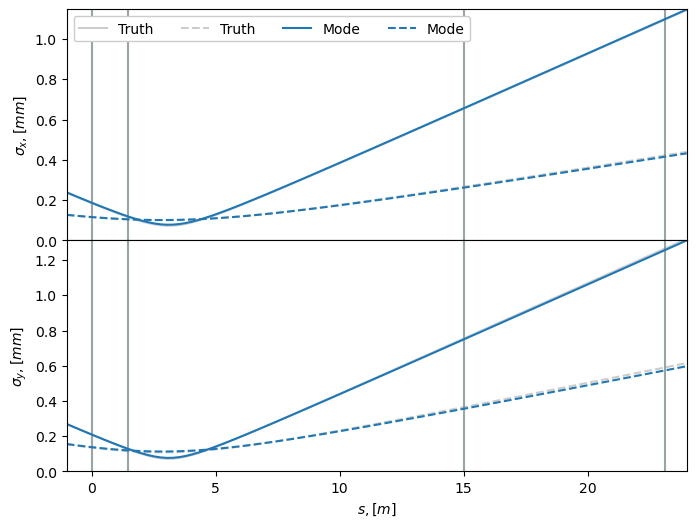

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [24]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

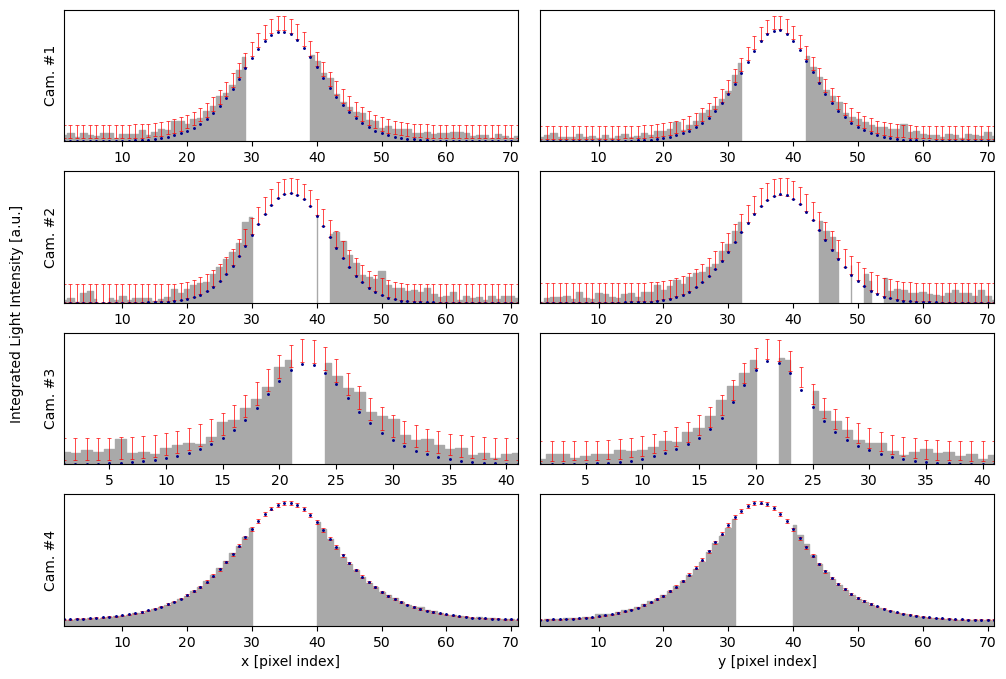

PyObject Text(0.08, 0.5, 'Integrated Light Intensity [a.u.]')

In [25]:
plot_projections(conv_matrices, event, event, params_array[1])